# FRA ESRI GIS Server

[Link to server location](https://fragis.fra.dot.gov/arcgis/rest/services/FRA)

# Calculating Track Mileage by Class

[Link to source files](https://data-usdot.opendata.arcgis.com/search?collection=Dataset&q=North%20American%20Rail%20Lines)

# Using OpenRailMap

In [47]:
import folium
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString

In [2]:
overpass_url = "https://overpass-api.de/api/interpreter"

In [3]:
state = "California"

overpass_query = f'[out:json][timeout:300];area["name"="{state}"]->.searchArea;(way["railway"="rail"]["maxspeed"](area.searchArea););out body geom;'

In [4]:
response = requests.get(overpass_url, params={"data": overpass_query})
data = response.json()

In [5]:
rail_features = []

for element in data["elements"]:
    if element["type"] == "way" and "geometry" in element:
        coordinates = [(point["lon"], point["lat"]) for point in element["geometry"]]
        geometry = LineString(coordinates)
        maxspeed = element["tags"].get("maxspeed", None)  # Extract maxspeed
        if maxspeed is not None:
            rail_features.append({"geometry": geometry, "maxspeed": maxspeed})

In [6]:
gdf = gpd.GeoDataFrame(rail_features, crs="EPSG:4326")

In [7]:
gdf = gdf.to_crs("EPSG:5070")
gdf["length_miles"] = gdf["geometry"].length * (0.000621371)  # Convert meters to miles

In [8]:
total_length = gdf["length_miles"].sum()

In [9]:
# Sum up the total length of all railways
total_length

np.float64(5543.594936382278)

California has ~6806 miles of track so not terribly off.

In [10]:
gdf

,geometry,maxspeed,length_miles
0,"LINESTRING (-2023255.433 1474592.107, -2023521...",79 mph,1.503528
1,"LINESTRING (-2017953.188 1458520.363, -2017955...",27 mph,0.794001
2,"LINESTRING (-1992573.431 1446902.085, -1992626...",70 mph,0.191493
3,"LINESTRING (-2017685.909 1459245.522, -2017729...",15 mph,0.284797
4,"LINESTRING (-2018074.371 1459011.124, -2018065...",15 mph,0.070330
...,...,...,...
10608,"LINESTRING (-2264507.763 1914651.928, -2264465...",79 mph,0.979210
10609,"LINESTRING (-2263596.068 1913367.844, -2263583...",79 mph,0.013133
10610,"LINESTRING (-2264511.019 1914649.494, -2264470...",79 mph,0.978075
10611,"LINESTRING (-2263600.843 1913367.609, -2263588...",79 mph,0.013299


In [11]:
# Clean and normalize maxspeed column: Convert to numeric (assuming speeds are in mph)
def parse_maxspeed(speed):
    try:
        if "mph" in speed:
            return int(speed.replace(" mph", "").strip())
    except:
        return 0

In [12]:
gdf["maxspeed_mph"] = gdf["maxspeed"].apply(parse_maxspeed)

In [34]:
# Binning maxspeed into predefined classes
bins = [0, 15, 30, 60, 80, 90, 110, 125, 160, 200]  # Bin edges
labels = ["class 1", "class 2", "class 3", "class 4", "class 5", "class 6", "class 7", "class 8", "class 9"]  # Bin labels

In [14]:
# Assign speed classes using pd.cut()
gdf["class"] = pd.cut(gdf["maxspeed_mph"], bins=bins, labels=labels, right=True, include_lowest=True)

In [15]:
len(gdf)

10613

In [16]:
# Group by speed class and calculate total miles in each class
class_totals = gdf.groupby("class", observed=False)["length_miles"].sum().reset_index()

In [17]:
# Calculate percentage of the total
total_miles = class_totals["length_miles"].sum()
class_totals["percentage"] = (class_totals["length_miles"] / total_miles) * 100

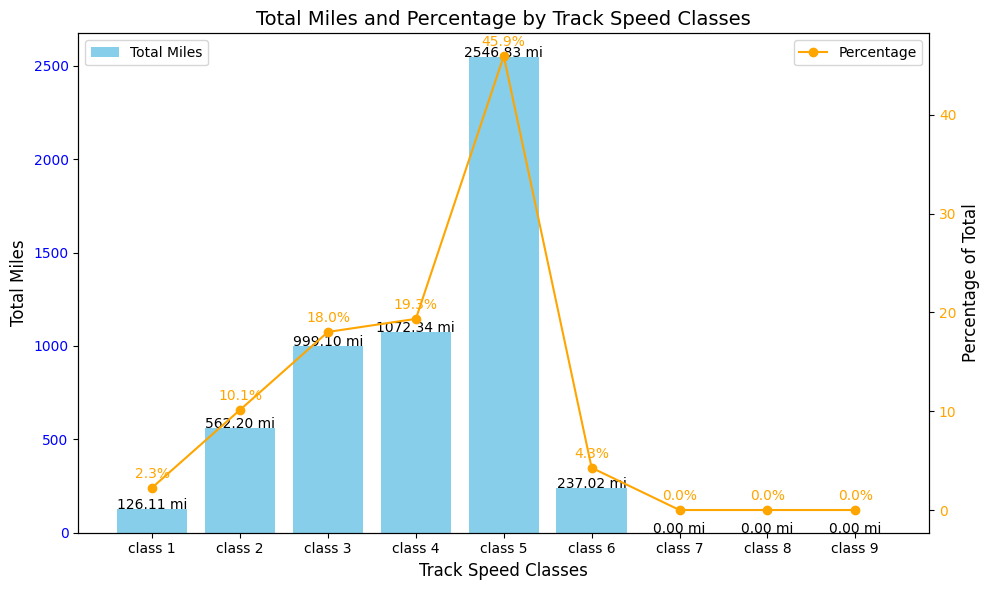

In [18]:
# Plot the results
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot: Total miles per class
ax1.bar(class_totals["class"], class_totals["length_miles"], color="skyblue", label="Total Miles")
ax1.set_xlabel("Track Speed Classes", fontsize=12)
ax1.set_ylabel("Total Miles", fontsize=12)
ax1.set_title("Total Miles and Percentage by Track Speed Classes", fontsize=14)
ax1.tick_params(axis="y", labelcolor="blue")

# Secondary y-axis: Percentage
ax2 = ax1.twinx()
ax2.plot(class_totals["class"], class_totals["percentage"], color="orange", marker="o", label="Percentage")
ax2.set_ylabel("Percentage of Total", fontsize=12)
ax2.tick_params(axis="y", labelcolor="orange")

# Add data labels on top of the bars
for i, row in class_totals.iterrows():
    ax1.text(row["class"], row["length_miles"] + 1, f'{row["length_miles"]:.2f} mi', ha="center", fontsize=10)
    ax2.text(row["class"], row["percentage"] + 1, f'{row["percentage"]:.1f}%', ha="center", fontsize=10, color="orange")

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

## Doing the same process for every state instead of just California

In [19]:
us_states = [
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado",
    "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho",
    "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana",
    "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota",
    "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada",
    "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina",
    "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania",
    "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas",
    "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin",
    "Wyoming"
]

In [20]:
full_geodataframe = gpd.GeoDataFrame()

for state in us_states:
    overpass_query = f'[out:json][timeout:3000];area["name"="{state}"]->.searchArea;(way["railway"="rail"]["maxspeed"](area.searchArea););out body geom;'

    response = requests.get(overpass_url, params={"data": overpass_query})
    data = response.json()

    rail_features = []

    for element in data["elements"]:
        if element["type"] == "way" and "geometry" in element:
            coordinates = [(point["lon"], point["lat"]) for point in element["geometry"]]
            geometry = LineString(coordinates)
            maxspeed = element["tags"].get("maxspeed", None)  # Extract maxspeed
            if maxspeed is not None:
                rail_features.append({"geometry": geometry, "maxspeed": maxspeed})

    try:
        gdf = gpd.GeoDataFrame(rail_features, crs="EPSG:4326")
        full_geodataframe = pd.concat([full_geodataframe, gdf], ignore_index=True)
    except:
        print(state)  # prints the states that didn't have data/failed

    

Hawaii


In [21]:
full_geodataframe["maxspeed_mph"] = full_geodataframe["maxspeed"].apply(parse_maxspeed)

In [22]:
# Assign speed classes using pd.cut()
full_geodataframe["class"] = pd.cut(full_geodataframe["maxspeed_mph"], bins=bins, labels=labels, right=True, include_lowest=True)

In [24]:
full_geodataframe

,geometry,maxspeed,maxspeed_mph,class
0,"LINESTRING (-85.82936 33.62923, -85.82924 33.6...",30 mph,30.0,class 3
1,"LINESTRING (-85.85396 33.65499, -85.85417 33.6...",10 mph,10.0,class 1
2,"LINESTRING (-85.85662 33.65240, -85.85663 33.6...",10 mph,10.0,class 1
3,"LINESTRING (-87.26035 30.99914, -87.26000 30.9...",20 mph,20.0,class 2
4,"LINESTRING (-86.32534 32.37672, -86.32562 32.3...",50 mph,50.0,class 4
...,...,...,...,...
117960,"LINESTRING (-105.22012 41.51903, -105.22029 41...",30 mph,30.0,class 3
117961,"LINESTRING (-109.07755 41.62395, -109.08334 41...",79 mph,79.0,class 5
117962,"LINESTRING (-109.13356 41.60695, -109.13367 41...",79 mph,79.0,class 5
117963,"LINESTRING (-109.19616 41.59192, -109.19538 41...",79 mph,79.0,class 5


In [26]:
full_geodataframe = full_geodataframe.to_crs("EPSG:5070")
full_geodataframe["length_miles"] = full_geodataframe["geometry"].length * (0.000621371)  # Convert meters to miles

In [35]:
# Group by speed class and calculate total miles in each class
class_totals = full_geodataframe.groupby("class", observed=False)["length_miles"].sum().reset_index()

In [36]:
# Calculate percentage of the total
total_miles = class_totals["length_miles"].sum()
class_totals["percentage"] = (class_totals["length_miles"] / total_miles) * 100

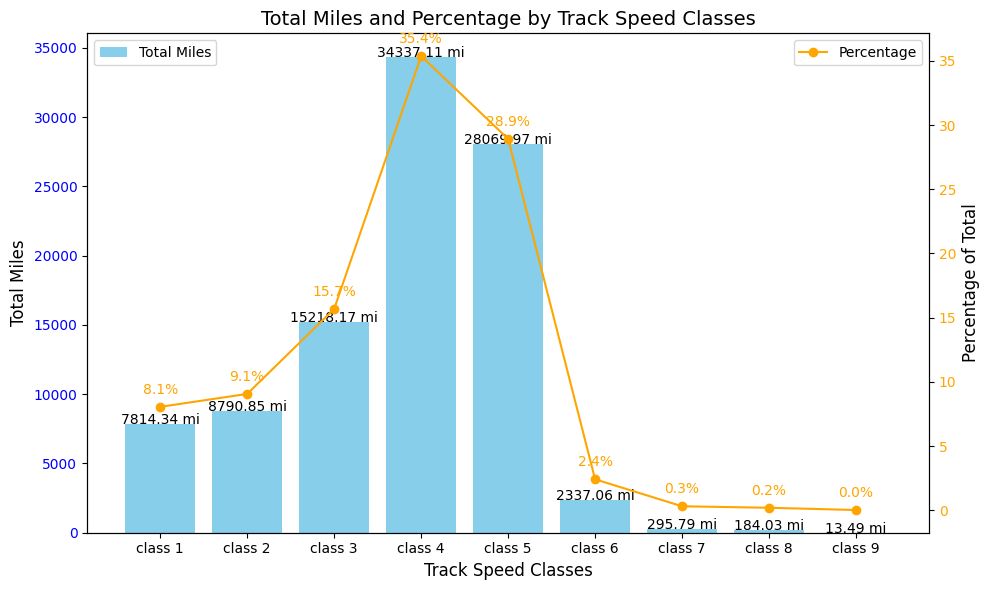

In [37]:
# Plot the results
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot: Total miles per class
ax1.bar(class_totals["class"], class_totals["length_miles"], color="skyblue", label="Total Miles")
ax1.set_xlabel("Track Speed Classes", fontsize=12)
ax1.set_ylabel("Total Miles", fontsize=12)
ax1.set_title("Total Miles and Percentage by Track Speed Classes", fontsize=14)
ax1.tick_params(axis="y", labelcolor="blue")

# Secondary y-axis: Percentage
ax2 = ax1.twinx()
ax2.plot(class_totals["class"], class_totals["percentage"], color="orange", marker="o", label="Percentage")
ax2.set_ylabel("Percentage of Total", fontsize=12)
ax2.tick_params(axis="y", labelcolor="orange")

# Add data labels on top of the bars
for i, row in class_totals.iterrows():
    ax1.text(row["class"], row["length_miles"] + 1, f'{row["length_miles"]:.2f} mi', ha="center", fontsize=10)
    ax2.text(row["class"], row["percentage"] + 1, f'{row["percentage"]:.1f}%', ha="center", fontsize=10, color="orange")

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [38]:
total_length = full_geodataframe["length_miles"].sum()
total_length

np.float64(97086.90348641116)

Total rail miles in the US ~ 150000

In [39]:
150000 - 97086

52914

In [40]:
52914 / 150000

0.35276

In [42]:
full_geodataframe[full_geodataframe['maxspeed_mph'] > 150]

,geometry,maxspeed,maxspeed_mph,class,length_miles
991,"LINESTRING (898653.350 1168025.085, 898713.410...",2015 mph,2015.0,NaN,0.350105
992,"LINESTRING (899242.108 1168094.553, 899193.653...",2015 mph,2015.0,NaN,0.388571
17813,"LINESTRING (-721184.557 1745109.514, -721229.1...",165 mph,165.0,class 9,8.324207
19716,"LINESTRING (-716332.567 1742737.441, -716268.1...",165 mph,165.0,class 9,5.165228


In [77]:
full_geodataframe = full_geodataframe.to_crs("EPSG:4326")

In [78]:
full_geodataframe.loc[17813].geometry.centroid.x

-104.33796168479839

In [81]:
m = folium.Map(
    location=[full_geodataframe.loc[19716].geometry.centroid.y, full_geodataframe.loc[19716].geometry.centroid.x],
    zoom_start=12).add_child(folium.GeoJson(data=full_geodataframe.loc[19716].geometry))
m